In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import glob 

files = ['api_data_aadhar_biometric_0_500000.csv','api_data_aadhar_biometric_500000_1000000.csv','api_data_aadhar_biometric_1000000_1500000.csv','api_data_aadhar_biometric_1500000_1861108.csv']

# Read and combine
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

print(f"Total shape: {df.shape}") 

Total shape: (1861108, 6)


In [13]:
df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,2025-03-01,Haryana,Mahendragarh,123029,280,577
1,2025-03-01,Bihar,Madhepura,852121,144,369
2,2025-03-01,Jammu and Kashmir,Punch,185101,643,1091
3,2025-03-01,Bihar,Bhojpur,802158,256,980
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815


In [10]:
df['date'] = pd.to_datetime(df['date'], format = "%d-%m-%Y")

In [14]:
df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,2025-03-01,Haryana,Mahendragarh,123029,280,577
1,2025-03-01,Bihar,Madhepura,852121,144,369
2,2025-03-01,Jammu and Kashmir,Punch,185101,643,1091
3,2025-03-01,Bihar,Bhojpur,802158,256,980
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815


In [18]:
df.columns

Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')

In [21]:
df.isna().sum().sum()

np.int64(0)

In [23]:
df.duplicated().sum()

np.int64(94896)

In [24]:
df.head(15)

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,2025-03-01,Haryana,Mahendragarh,123029,280,577
1,2025-03-01,Bihar,Madhepura,852121,144,369
2,2025-03-01,Jammu and Kashmir,Punch,185101,643,1091
3,2025-03-01,Bihar,Bhojpur,802158,256,980
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815
5,2025-03-01,Maharashtra,Ratnagiri,416702,155,529
6,2025-03-01,Gujarat,Anand,388130,75,143
7,2025-03-01,Gujarat,Gandhinagar,382421,192,298
8,2025-03-01,Odisha,Dhenkanal,759025,122,214
9,2025-03-01,Gujarat,Valsad,396055,67,85


--- DIAGNOSTIC CHECK ---
Current Columns in 'df':
['date', 'state', 'district', 'pincode', 'Child_Updates', 'Adult_Updates']

 SUCCESS: Columns found and renamed!

--- TOP 10 'MANUAL LABOR' DISTRICTS (Fading Fingerprints) ---
              state             district  Labor_Index
547     Maharashtra          Nandurbar *   101.812500
730          Punjab           Nawanshahr    22.402235
533     Maharashtra            Gondiya *    20.014925
218           Delhi           North East    18.481822
522     Maharashtra                  Bid    17.386617
705     Pondicherry             Karaikal    16.081250
29   Andhra Pradesh        Mahabub Nagar    15.851582
230         Gujarat            Ahmadabad    15.369520
486  Madhya Pradesh              Mauganj    11.783133
523     Maharashtra              Buldana    10.277059
543     Maharashtra  Mumbai( Sub Urban )     9.852423
356       Jharkhand             Garhwa *     9.437383
441          Kerala             Kasargod     9.132701
729          Punja

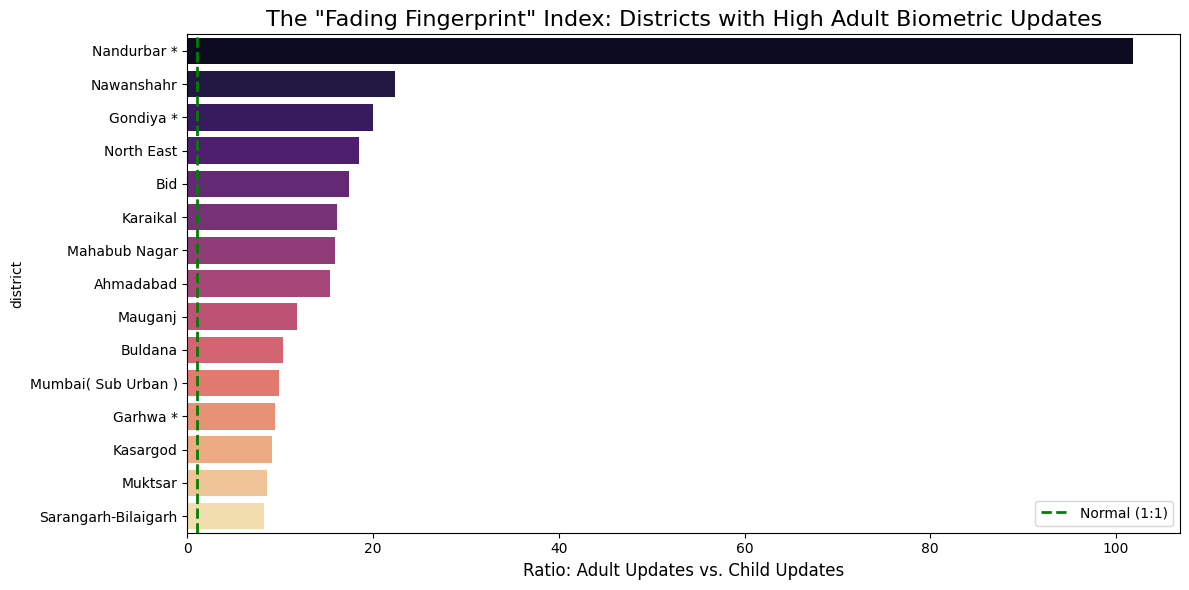

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- DIAGNOSTIC CHECK ---")
print("Current Columns in 'df':")
print(df.columns.tolist())

# --- SMART RENAMING ---
# We try to map whatever exists to the names we need
df_bio = df.copy() # Work on a copy to be safe

# Map Dictionary: { "Existing Name": "New Standard Name" }
# We check for the names you provided in the screenshot
rename_map = {
    'bio_age_17_': 'Adult_Updates',
    'bio_age_5_17': 'Child_Updates',
    'age_18_greater': 'Adult_Updates', # Fallback if using old data
    'age_5_17': 'Child_Updates'        # Fallback if using old data
}

df_bio.rename(columns=rename_map, inplace=True)

# --- CHECK IF FIX WORKED ---
required_cols = ['Adult_Updates', 'Child_Updates']
missing_cols = [col for col in required_cols if col not in df_bio.columns]

if missing_cols:
    print(f"\n❌ CRITICAL ERROR: I still cannot find these columns: {missing_cols}")
    print("Please reload your Biometric CSV file specifically into 'df' and try again.")
else:
    print("\n SUCCESS: Columns found and renamed!")
    
    # --- RUN LABOR INDEX ANALYSIS ---
    # Group by District
    district_bio = df_bio.groupby(['state', 'district'])[['Adult_Updates', 'Child_Updates']].sum().reset_index()

    # Filter noise (> 1000 updates)
    district_bio = district_bio[district_bio['Adult_Updates'] + district_bio['Child_Updates'] > 1000]

    # Calculate Labor Index
    district_bio['Labor_Index'] = district_bio['Adult_Updates'] / district_bio['Child_Updates']

    # Sort
    labor_hubs = district_bio.sort_values(by='Labor_Index', ascending=False).head(15)

    print("\n--- TOP 10 'MANUAL LABOR' DISTRICTS (Fading Fingerprints) ---")
    print(labor_hubs[['state', 'district', 'Labor_Index']])

    # Visualize
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=labor_hubs,
        x='Labor_Index',
        y='district',
        hue='district',
        palette='magma',
        legend=False
    )
    plt.axvline(x=1.0, color='green', linestyle='--', linewidth=2, label='Normal (1:1)')
    plt.title('The "Fading Fingerprint" Index: Districts with High Adult Biometric Updates', fontsize=16)
    plt.savefig('labor_index.png', dpi=300, bbox_inches='tight')
    plt.xlabel('Ratio: Adult Updates vs. Child Updates', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [40]:
df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,2025-03-01,Haryana,Mahendragarh,123029,280,577
1,2025-03-01,Bihar,Madhepura,852121,144,369
2,2025-03-01,Jammu and Kashmir,Punch,185101,643,1091
3,2025-03-01,Bihar,Bhojpur,802158,256,980
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815


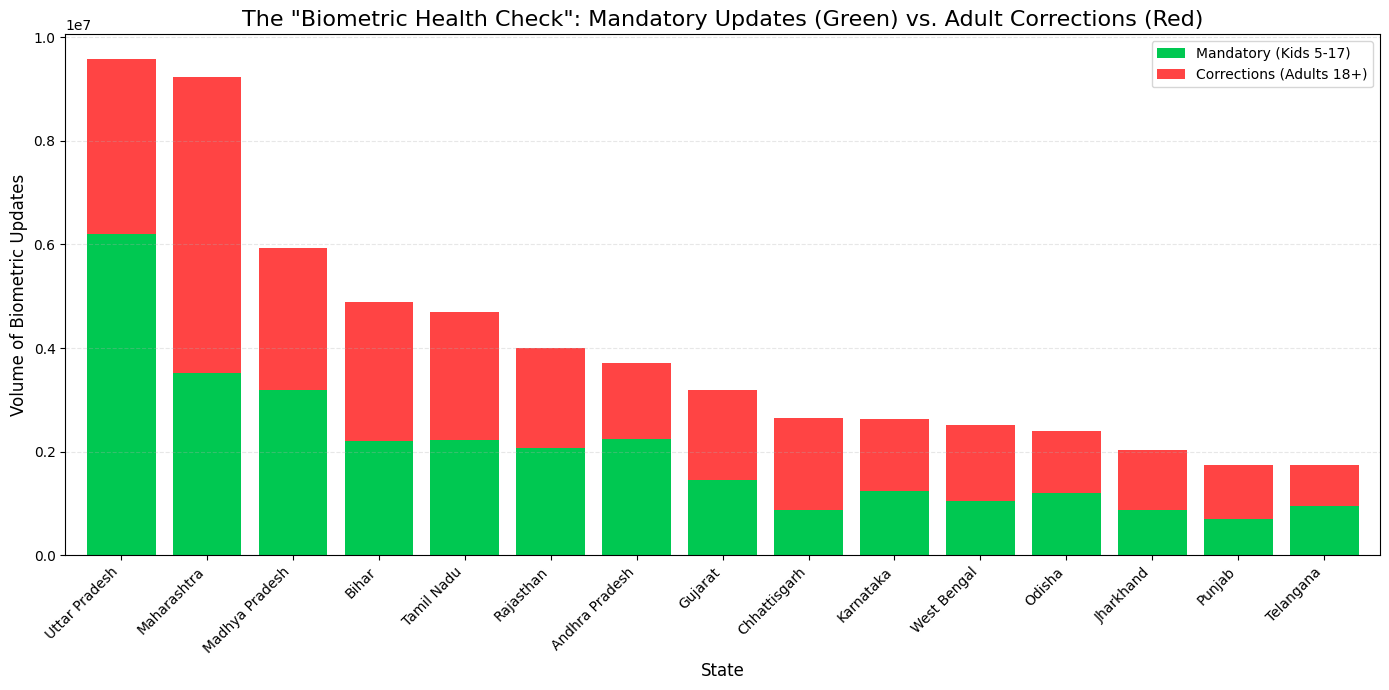

In [43]:
# --- STEP 1: PREPARE DATA ---
# (Assuming 'df_bio' or 'df' is ready from the previous step)
# We ensure the columns are correct
if 'Adult_Updates' not in df.columns:
    df.rename(columns={'bio_age_17_': 'Adult_Updates', 'bio_age_5_17': 'Child_Updates'}, inplace=True)

# Group by State
state_mix = df.groupby('state')[['Child_Updates', 'Adult_Updates']].sum()

# Sort by Total Volume (Busy states first)
state_mix['Total'] = state_mix['Child_Updates'] + state_mix['Adult_Updates']
state_mix = state_mix.sort_values(by='Total', ascending=False).head(15)
state_mix = state_mix.drop(columns=['Total']) # Drop total so it doesn't mess up the chart

# --- STEP 2: VISUALIZE (STACKED BAR) ---
ax = state_mix.plot(
    kind='bar', 
    stacked=True, 
    figsize=(14, 7), 
    color=['#00C851', '#ff4444'], # Green for Kids, Red for Adults
    width=0.8
)

plt.title('The "Biometric Health Check": Mandatory Updates (Green) vs. Adult Corrections (Red)', fontsize=16)
plt.savefig('Compliance_index.png', dpi=300, bbox_inches='tight')
plt.ylabel('Volume of Biometric Updates', fontsize=12)
plt.xlabel('State', fontsize=12)
plt.legend(['Mandatory (Kids 5-17)', 'Corrections (Adults 18+)'])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### UP is actually doing a great job enforcing school updates (the Green part is high).However, because UP's population is so massive, the "Adult Maintenance" volume (the Red part) is still larger than any other state's entire workload.
# Insight: 
## UP doesn't have a compliance problem; it has a Volume Problem. Even if they do everything right, the sheer number of adults needing corrections will crash the system unless they get Self-Service Kiosks to handle the 'Red' load."